In [ ]:
# install fasttext
!pip install -q fastText
!pip install -q emoji

In [ ]:
# import library and setting options
import fasttext
import emoji
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
import string
import re
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [ ]:
# test emoji
emoji.demojize('🤔')

':thinking_face:'

In [ ]:
':thinking_face:'

':thinking_face:'

In [ ]:
# data loading
filepath = '/content/drive/My Drive/CS410_Text_Info_Systems/Final Project/ClassificationCompetition/data/'

trainname = 'train.jsonl'
df_train = pd.read_json(filepath + trainname, lines=True)

testname = 'test.jsonl'
df_test = pd.read_json(filepath + testname, lines=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     5000 non-null   object
 1   response  5000 non-null   object
 2   context   5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB


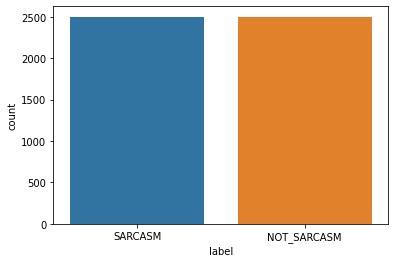

In [ ]:
# show distribution of labels in the training set
sns.countplot(x = 'label', data = df_train)

In [ ]:
# punctuations
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation]) + '|\\’'
print(RE_PUNCTUATION)

\!|\"|\#|\$|\%|\&|\'|\(|\)|\*|\+|\,|\-|\.|\/|\:|\;|\<|\=|\>|\?|\@|\[|\\|\]|\^|_|\`|\{|\||\}|\~|\’


In [ ]:
# data cleaning and emoji conversion
# df_train['response_clean'] = df_train['response'].str.lower().str.replace('@user','').str.replace(RE_PUNCTUATION,'').str.replace(' +', ' ').str.strip()
# df_test['response_clean'] = df_test['response'].str.lower().str.replace('@user','').str.replace(RE_PUNCTUATION,'').str.replace(' +', ' ').str.strip()
df_train['response_clean'] = df_train['response'].str.replace('@USER','').apply(lambda x: emoji.demojize(x).replace(':',' ').replace('_',' ')).str.replace(RE_PUNCTUATION,'').str.replace(' +', ' ').str.strip()
df_test['response_clean'] = df_test['response'].str.replace('@USER','').apply(lambda x: emoji.demojize(x).replace(':',' ').replace('_',' ')).str.replace(RE_PUNCTUATION,'').str.replace(' +', ' ').str.strip()

In [ ]:
df_train

,label,response,context,response_clean
0,SARCASM,@USER @USER @USER I don't get this .. obviously you do care or you would've moved right along .....,"[A minor child deserves privacy and should be kept out of politics . Pamela Karlan , you should ...",I dont get this obviously you do care or you wouldve moved right along instead you decided to ca...
1,SARCASM,@USER @USER trying to protest about . Talking about him and his labels and they label themselves...,"[@USER @USER Why is he a loser ? He's just a Press Secretary, @USER @USER having to make up excu...",trying to protest about Talking about him and his labels and they label themselves WTF does that...
2,SARCASM,"@USER @USER @USER He makes an insane about of money from the MOVIES , Einstein ! #LearnHowTheSys...",[Donald J . Trump is guilty as charged . The evidence is clear . If your Senator votes to acquit...,He makes an insane about of money from the MOVIES Einstein LearnHowTheSystemWorks
3,SARCASM,@USER @USER Meanwhile Trump won't even release his SAT scores and his Wharton professors said he...,"[Jamie Raskin tanked Doug Collins . Collins looks stupid . <URL>, @USER But not half as stupid a...",Meanwhile Trump wont even release his SAT scores and his Wharton professors said he was the dumb...
4,SARCASM,"@USER @USER Pretty Sure the Anti-Lincoln Crowd Claimed That "" Democracy Was on the Ballot "" in 1...","[Man ... y ’ all gone “ both sides ” the apocalypse one day . <URL>, @USER They already did . Ob...",Pretty Sure the AntiLincoln Crowd Claimed That Democracy Was on the Ballot in 1860 too They Thou...
...,...,...,...,...
4995,NOT_SARCASM,@USER You don't . I have purchased a lot on Amazon ( check my entire spending history ) and toda...,[@USER Apologies for the inconvenience you faced with your order . We would like to take a close...,You dont I have purchased a lot on Amazon check my entire spending history and today you guys ju...
4996,NOT_SARCASM,@USER #Emotions you say 🤔 never knew that I think I ’ m just happy when I ’ m #eating and when I...,"[@USER 🤔 idk tho , I think I ’ m #hungry . But that ’ s definitely just a #mango and not a #sala...",Emotions you say thinking face never knew that I think I m just happy when I m eating and when I...
4997,NOT_SARCASM,"@USER @USER @USER You are so right ... "" Yes ! #Silence is not #Privacy is not ""","[@USER @USER @USER Peace to you , and two countries certainly seems more ideal than a greater nu...",You are so right Yes Silence is not Privacy is not
4998,NOT_SARCASM,@USER @USER @USER Another lazy delusional voter who takes the word of corporatists at face value...,"[Bernie Sanders told Elizabeth Warren in private 2018 meeting that a woman can't win , sources s...",Another lazy delusional voter who takes the word of corporatists at face value instead of doing ...


In [ ]:
# emoji test
emoji.demojize('🤔')

':thinking_face:'

In [ ]:
# shuffle training example
# labels = df_train['label'].tolist()
# features = df_train['response'].tolist()
df_train_shuffle = shuffle(df_train)
df_train_shuffle['response_clean']

3893    May we ALL including ALL our struggling loved ones come back to Our Lord Our Gods wisdom that YE...
646                                                                     says the man who writes for the sun
822     YAY theyre so nice I had one and it was white and washed it with pink underwear and literally ma...
230     Saddam was more evil more powerful and more dangerous Removing him with any kind of strategy mus...
4270    711 She begged Aphrodite to let her see Eros and the goddess gave her 3 impossible tasks to comp...
                                                       ...                                                 
3368    Thank you dear Elka It will test me the most difficult part of my life But while my John is stil...
3468    Me too When I saw the still from the video in today s email I was a bit ‘ Yeah right Adriene wha...
126                          thinking the same thing Couldnt read about putting phone down without my phone
1150                   Thats

In [ ]:
# data preparation for fasttext
with open('fasttext_input_sarcastic_comments.txt', 'w') as f:
    for each_text, each_label in zip(df_train_shuffle['response_clean'], df_train_shuffle['label']):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [ ]:
# QC the output file and split into training and validation sets
!wc fasttext_input_sarcastic_comments.txt
!head -n 4500 fasttext_input_sarcastic_comments.txt > twitter.train
!tail -n 500 fasttext_input_sarcastic_comments.txt > twitter.valid

  5000 118096 707842 fasttext_input_sarcastic_comments.txt


In [ ]:
# train model is training set and hyperparameter tuning
model0 = fasttext.train_supervised(input='twitter.train', lr=0.1, epoch=50, wordNgrams=3)
# model0.save_model("model_0.bin")
model0.test("twitter.valid")

(500, 0.77, 0.77)

In [ ]:
# get precision, recall and f1 scores
y_true = df_train_shuffle['label'].tail(500).tolist()
y_pred = []
for response in df_train_shuffle['response_clean'].tail(500):
    pred = re.sub('__label__','',model0.predict(response)[0][0])
    y_pred.append(pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)
print(precision, recall, f1)

[0.76855895 0.77121771] [0.7394958  0.79770992] [0.75374732 0.78424015]


In [ ]:
# train model with all the data available using tuned parameters
model1 = fasttext.train_supervised(input='fasttext_input_sarcastic_comments.txt', lr=.1, epoch=50, wordNgrams=3)
model1.test("twitter.valid")

(500, 1.0, 1.0)

In [ ]:
# output label for grader
i = 1
with open('answer.txt', 'w') as f:
  for response in df_test['response_clean']:
    pred = re.sub('__label__','',model1.predict(response)[0][0])
    f.writelines(f'twitter_{str(i)},{pred}\n')
    i += 1